In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.metrics import explained_variance_score, \
    mean_absolute_error, \
    median_absolute_error
from sklearn.model_selection import train_test_split

2022-04-25 10:40:22.824436: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-25 10:40:22.824686: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [59]:
# read in the csv data into a pandas data frame and set the date as the index
df = pd.read_csv('JaipurFinalCleanData.csv').set_index('date')

# execute the describe() function and transpose the output so that it doesn't overflow the width of the screen
df.describe().T
print(len(df))

676


In [3]:
# execute the info() function
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 676 entries, 2016-05-04 to 2018-03-11
Data columns (total 39 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   meantempm        676 non-null    int64  
 1   maxtempm         676 non-null    int64  
 2   mintempm         676 non-null    int64  
 3   meantempm_1      676 non-null    float64
 4   meantempm_2      676 non-null    float64
 5   meantempm_3      676 non-null    float64
 6   meandewptm_1     676 non-null    float64
 7   meandewptm_2     676 non-null    float64
 8   meandewptm_3     676 non-null    float64
 9   meanpressurem_1  676 non-null    float64
 10  meanpressurem_2  676 non-null    float64
 11  meanpressurem_3  676 non-null    float64
 12  maxhumidity_1    676 non-null    float64
 13  maxhumidity_2    676 non-null    float64
 14  maxhumidity_3    676 non-null    float64
 15  minhumidity_1    676 non-null    float64
 16  minhumidity_2    676 non-null    float64
 17  minhu

In [4]:
# First drop the maxtempm and mintempm from the dataframe
df = df.drop(['mintempm', 'maxtempm'], axis=1)

# X will be a pandas dataframe of all columns except meantempm
X = df[[col for col in df.columns if col != 'meantempm']]

# y will be a pandas series of the meantempm
y = df['meantempm']

In [5]:
# split data into training set and a temporary set using sklearn.model_selection.traing_test_split
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.2, random_state=23)

In [6]:
# take the remaining 20% of data in X_tmp, y_tmp and split them evenly
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5, random_state=23)

X_train.shape, X_test.shape, X_val.shape
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))

Training instances   540, Training features   36
Validation instances 68, Validation features 36
Testing instances    68, Testing features    36


In [7]:
feature_cols = [tf.feature_column.numeric_column(col) for col in X.columns]

In [12]:
tf.version #to check it has the latest version over 1.21 if not then install with conda update -f -c conda-forge tensorflow

<module 'tensorflow._api.v2.version' from '/usr/local/lib/python3.8/dist-packages/tensorflow/_api/v2/version/__init__.py'>

In [9]:
regressor = tf.estimator.DNNRegressor(feature_columns=feature_cols,
                                      hidden_units=[50, 50],
                                      model_dir='tf_wx_model')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_model_dir': 'tf_wx_model', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_steps': None, '_save_checkpoints_secs': 600, '_session_config': allow_soft_placement: true
graph_options {
  rewrite_options {
    meta_optimizer_iterations: ONE
  }
}
, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_log_step_count_steps': 100, '_train_distribute': None, '_device_fn': None, '_protocol': None, '_eval_distribute': None, '_experimental_distribute': None, '_experimental_max_worker_delay_secs': None, '_session_creation_timeout_secs': 7200, '_checkpoint_save_graph_def': True, '_service': None, '_cluster_spec': ClusterSpec({}), '_task_type': 'worker', '_task_id': 0, '_global_id_in_cluster': 0, '_master': '', '_evaluation_master': '', '_is_chief': True, '_num_ps_replicas': 0, '_num_worker_replicas': 1}


In [13]:
def wx_input_fn(X, y=None, num_epochs=None, shuffle=True, batch_size=260): # 260 is used as we have approx 570 dataset for training
    return tf.compat.v1.estimator.inputs.pandas_input_fn(x=X,
                                               y=y,
                                               num_epochs=num_epochs,
                                               shuffle=shuffle,
                                               batch_size=batch_size)

In [14]:
evaluations = []
STEPS = 260
for i in range(100):
    regressor.train(input_fn=wx_input_fn(X_train, y=y_train), steps=STEPS)
    evaluation = regressor.evaluate(input_fn=wx_input_fn(X_val, y_val,
                                                         num_epochs=1,
                                                         shuffle=False),
                                    steps=1)
    evaluations.append(regressor.evaluate(input_fn=wx_input_fn(X_val,
                                                               y_val,
                                                               num_epochs=1,
                                                               shuffle=False)))



Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling model_fn.


2022-04-25 10:49:22.326518: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-04-25 10:49:22.326615: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-04-25 10:49:22.326665: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ayushsingh-ThinkPad): /proc/driver/nvidia/version does not exist


Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.


2022-04-25 10:49:24.853525: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Instructions for updating:
To construct input pipelines, use the `tf.data` module.
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 0...
INFO:tensorflow:Saving checkpoints for 0 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 0...
INFO:tensorflow:loss = 1794.3156, step = 0
INFO:tensorflow:global_step/sec: 42.0647
INFO:tensorflow:loss = 57.222504, step = 100 (2.392 sec)
INFO:tensorflow:global_step/sec: 46.1945
INFO:tensorflow:loss = 32.94228, step = 200 (2.150 sec)
INFO:tensorflow:Calling checkpoint listeners before saving checkpoint 260...
INFO:tensorflow:Saving checkpoints for 260 into tf_wx_model/model.ckpt.
INFO:tensorflow:Calling checkpoint listeners after saving checkpoint 260...
INFO:tensorflow:Loss for final step: 31.182106.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evalua

In [31]:
evaluations[0]

{'average_loss': 28.206331,
 'label/mean': 26.57353,
 'loss': 28.206331,
 'prediction/mean': 25.07259,
 'global_step': 260}

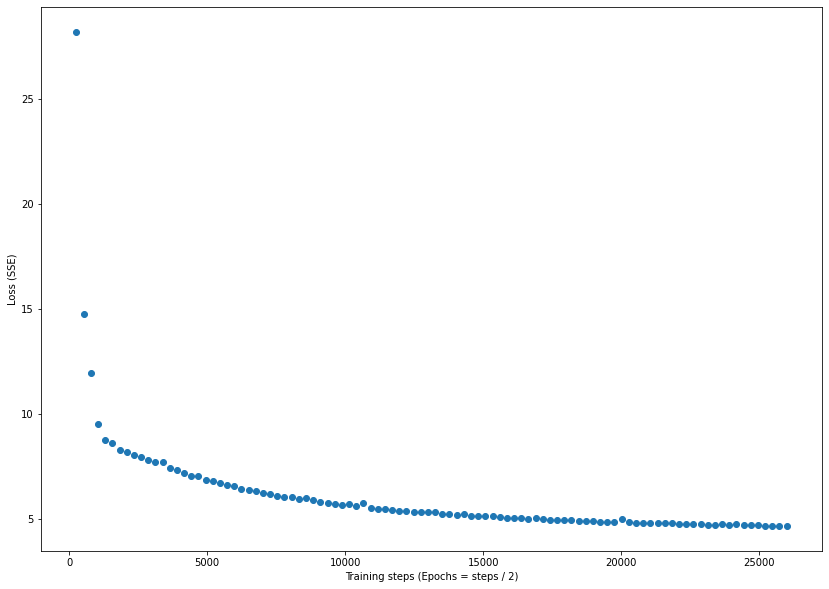

In [32]:
import matplotlib.pyplot as plt
%matplotlib inline

# manually set the parameters of the figure to and appropriate size
plt.rcParams['figure.figsize'] = [14, 10]

loss_values = [ev['loss'] for ev in evaluations]
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)
plt.xlabel('Training steps (Epochs = steps / 2)')
plt.ylabel('Loss (SSE)')
plt.show()

In [44]:
pred = regressor.predict(input_fn=wx_input_fn(X_test,
                                              num_epochs=1,
                                              shuffle=False))

#testpred=np.array([p for p in pred])
#print(testpred)
predictions = np.array([p['predictions'][0] for p in pred])


INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from tf_wx_model/model.ckpt-26000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


In [53]:
print(predictions[:20])

expected_values=predictions[:20]


[27.760712 33.483253 26.455482 17.720612 16.783539 20.85173  31.759491
 30.534378 22.355392 29.15487  28.53859  25.314697 23.86325  20.59259
 32.935974 35.157898 28.319336 26.688911 31.403473 29.872597]


In [54]:
print()
print()



The Explained Variance: 0.93
The Mean Absolute Error: 1.28 degrees Celcius
The Median Absolute Error: 0.89 degrees Celcius


[27.760712 33.483253 26.455482 17.720612 16.783539 20.85173  31.759491
 30.534378 22.355392 29.15487  28.53859  25.314697 23.86325  20.59259
 32.935974 35.157898 28.319336 26.688911 31.403473 29.872597]


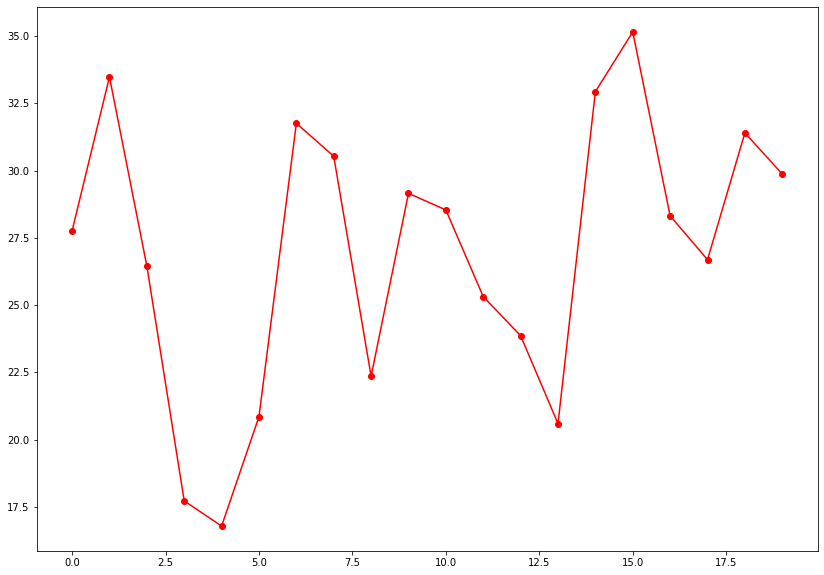

In [56]:

x_values=range(20)
plt.plot(x_values,expected_values,color="red",marker="o")
print(expected_values)

plt.show()

In [57]:
print("The Explained Variance: %.2f" % explained_variance_score(
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f degrees Celcius" % mean_absolute_error(
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f degrees Celcius" % median_absolute_error(
                                            y_test, predictions))

The Explained Variance: 0.93
The Mean Absolute Error: 1.28 degrees Celcius
The Median Absolute Error: 0.89 degrees Celcius
